In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

print(tf.config.get_visible_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import tensorflow as tf

# ^^^ pyforest auto-imports - don't write above this line
# association of paths
dataset_path = "..\Datasets_test\OneDrive_2022-09-22\Dataset projet"

In [3]:
# Le train_set
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split= .2,
    subset = "training",
    seed=42,
    shuffle=True,
    batch_size=128,
)

# Le test_set
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split= .2, 
    subset = "validation", 
    seed=42,
    shuffle=True,
    batch_size=128,
)

Found 21406 files belonging to 3 classes.
Using 17125 files for training.
Found 21406 files belonging to 3 classes.
Using 4281 files for validation.


In [4]:
class_names = train_set.class_names
print(class_names)

['Dataset Livrable 1 - Photo', 'Dataset Livrable 1 - Sketch', 'Dataset Livrable 1 - Text']


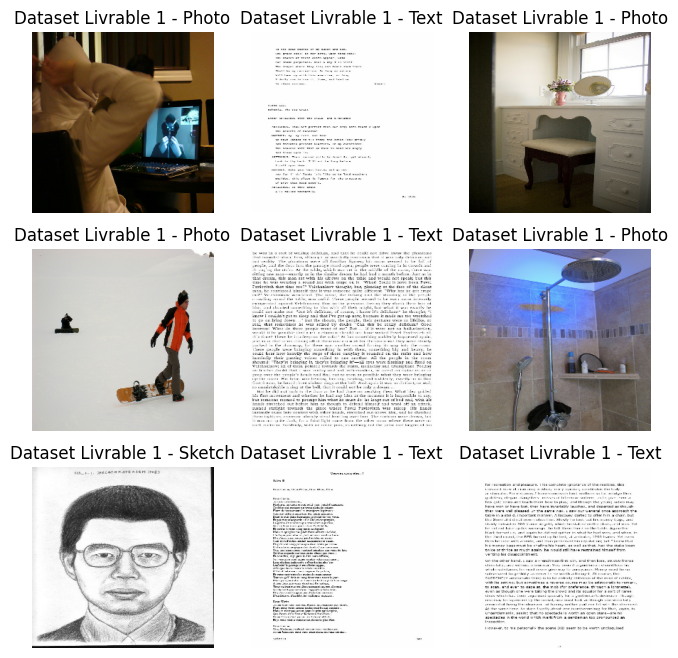

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
print(type(train_set))
for image_batch, labels_batch in train_set:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
(128, 256, 256, 3)
(128,)


Il est maintenant temps de configurer notre environnement pour passer au vif du sujet.

# 3. Configuration de l'environnement pour l'entrainement
Dans cette partie, vous devrez utiliser les fonctions [`Dataset.cache`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) et [`Dataset.prefetch`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) afin de configurer les données pour améliorer les performances de la façon suivante :
- `Dataset.cache()` : Cette fonction sert à forcer le maintien des données en cache dans la mémoire. Vu que le réseau de neurones fait plusieurs passes (qu'on nomme _époque_ ou _epoch_ en anglais) sur les données durant l'apprentissage, cette fonction permet de ne pas avoir à recharger les images à chaque fois. 
- `Dataset.prefetch()` : Cette fonction permet de faire le prétraitement de l'élément courant du jeu de données (par exemple le batch suivant) en même temps que l'entrainement/évaluation du batch courant par le modèle. Dans un environnement multi-processeurs ou multi-cœur, c'est un gain de temps non négligeable.

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

# 4. La normalisation
Généralement, en machine learning, vous aurez souvent besoin de transformer l'échelle de valeur des attributs de sorte que les attributs prennent des valeurs qui sont dans le même intervalle. Cette transformation aura pour effet de rendre l'apprentissage plus uniforme au niveau des différents attributs et donc de ne pas surestimer l'importance d'un attribut par rapport à un autre (cela peut arriver si par exemple les attributs ont des échelles complètement différentes). Dans ce workshop vous allez appliquer [la normalisation](https://medium.com/@darrenyaoyao.huang/why-we-need-normalization-in-deep-learning-from-batch-normalization-to-group-normalization-d06ea0e59c17) qui consiste juste à diviser l'entrée (la valeur d'une composante RVB d'un pixel) par 255 pour transformer l'entrée dans l'intervalle [0, 1]. Ce traitement se fait à l'aide de la fonction [`layers.experimental.preprocessing.Rescaling`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling).

In [8]:
num_classes = 3 # Nombre de classes et donc aussi nombre de neurones dans la dernière couche
model = Sequential()

Généralement, en machine learning, vous aurez souvent besoin de transformer l'échelle de valeur des attributs de sorte que les attributs prennent des valeurs qui sont dans le même intervalle. Cette transformation aura pour effet de rendre l'apprentissage plus uniforme au niveau des différents attributs et donc de ne pas surestimer l'importance d'un attribut par rapport à un autre (cela peut arriver si par exemple les attributs ont des échelles complètement différentes). 

Dans ce workshop vous allez appliquer [la normalisation](https://medium.com/@darrenyaoyao.huang/why-we-need-normalization-in-deep-learning-from-batch-normalization-to-group-normalization-d06ea0e59c17) qui consiste juste à diviser l'entrée (la valeur d'une composante RVB d'un pixel) par 255 pour transformer l'entrée dans l'intervalle [0, 1]. Vous utiliserez la couche [`layers.experimental.preprocessing.Rescaling`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling) à cet effet.

In [9]:
model.add(tf.keras.layers.Rescaling(
    #A COMPLETER
    1./255
    )
)

Après cela, vous allez implémenter votre premier **bloc convolutif**. Un bloc convolutif est constitué de deux couches spécifiques aux réseaux de neurones convolutifs : la [couche convolutive](https://fr.wikipedia.org/wiki/R%C3%A9seau_neuronal_convolutif#Couche_de_convolution_(CONV)) (qui a été introduite brièvement), et la [couche de pooling](https://fr.wikipedia.org/wiki/R%C3%A9seau_neuronal_convolutif#Couche_de_pooling_(POOL)). Pour plus de détails sur ces couches au niveau, [ce Notebook](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_06_2_cnn.ipynb) sera utile. Les architectures gèrent ces couches de manière potentiellement différentes, mais il est courant d'utiliser ces couches de la manière suivante :

- La couche convolutive: Elle sert à détecter la présence d'attributs au niveau de l'image en utilisant l'opération de convolution, et ainsi extraire de plus en plus de caractéristiques. L'application de cette couche vise généralement à retourner des attributs de plus haut niveau sur l'image. Elle a pour effet d’augmenter la profondeur de l’image si le nombre de filtres est assez grand. Dans ce workshop, vous devez faire un [padding](https://ayeshmanthaperera.medium.com/what-is-padding-in-cnns-71b21fb0dd7) de sorte que la taille de la sortie reste la même par rapport à l'entrée. Il devrait y avoir 16 filtres de taille `(3,3)` dans cette première couche. N'oubliez pas que la sortie de cette couche doit être passée à une fonction d'activation (la fonction ReLU).

- La couche de pooling : Elle sert à compresser la sortie de la couche convolutive en prenant l'information la plus saillante de celle-ci. La sortie de la couche convolutive est divisée en blocs carrés de même taille. Pour chaque bloc la valeur maximale est retenue et les autres sont ignorés, la hauteur et la largeur de la couche sont réduites.

Faire passer la sortie d’une couche à un bloc de convolution permet d’un coté de déceler des attributs de plus haut niveau en combinant ceux de la couche précédente, d’un autre côté de réduire le nombre de neurones de façon à prendre les neurones les plus actives et qui sont nécessaires à la tache (grace à la couche de pooling). Vous devez donc ajuter les deux couches en vous référant à la [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/). Précisons qu'on vous demande de faire un pooling qui prend le maximum et que l'entrée consiste en des images 2D.

In [10]:
# Couche convolutive
model.add(
    #A COMPLETER
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same'),
)
# Couche de pooling
model.add(
    #A COMPLETER
    tf.keras.layers.MaxPooling2D(),
)

Implémentez le reste du réseau. Celui-ci devra contenir les éléments suivants :
- Un bloc convolutif similaire au précédent contenant 32 filtres de hauteur et de largeur de 3.
- Un bloc convolutif similaire au précédent contenant 64 filtres de hauteur et de largeur de 3.
- Une couche contenant la couche précédente aplatie (flatten).
- Une couche entièrement connectée de taille 128.
- La couche finale complètement connectée (dense) retournant le résultat de la classification.

Quelques remarques devront être relevées au sujet de cette architecture, vous pouvez vous appuyer sur le premier schéma de CNN pour suivre les remarques de cette partie :
- Les CNNs sont généralement constitués de deux parties, une partie composée de blocs convolutifs, et une partie composée de couches denses. La première partie sert, indirectement, à compresser la taille de l’image pour la remettre en entrée à la deuxième partie qui aura beaucoup moins de neurones que le nombre d’origine de pixels de l’images.
- Les couches de la partie de blocs convolutifs gagnent en profondeur et perdent en hauteur et en largeur à mesure qu’on avance vers des couches profondes dans le réseau. Nous avons besoin de cela car le réseau a besoin d’apprendre à reconnaitre des attributs descriptifs de l’image pour faire de la classification. Le nombre d’attributs s’accroit à mesure qu’on avance dans le réseau, ceci signifie que les neurones des couches profondes perdent en informations spatiales mais gagnent en information descriptives sur l’image.
Quel est l’intérêt en mémoire et en temps de calcul de l’utilisation des architectures par réseau de neurones convolutifs ? (Intéressez-vous au nombre de paramètres).
<em>À COMPLÉTER</em>


In [11]:
# Bloc convolutif ou la taille du filtre est de (32, 3)
model.add(
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    #tf.keras.layers.MaxPooling2D(),
)

# Couche de pooling
model.add(
    #A COMPLETER
    tf.keras.layers.MaxPooling2D(),
)

# Bloc convolutif ou la taille du filtre est de (64, 3)
model.add(
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    #tf.keras.layers.MaxPooling2D(),
)

# Couche de pooling
model.add(
    #A COMPLETER
    tf.keras.layers.MaxPooling2D(),
)

# Applatissement de la couche
model.add(
    tf.keras.layers.Flatten(),
)

# Couche entièrement connectée (couche dense)
model.add(
    tf.keras.layers.Dense(128, activation='relu'),
)

# Couche entièrement connectée retournant le résultat de la classification
model.add(
    tf.keras.layers.Dense(num_classes)
)



Choisissons donc cette métrique et compilons le modèle.

In [12]:
model.compile(optimizer =  "adam",
              loss =  tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#model.summary()

Finalement, vous avez à préciser l'évolution de l'erreur d'entrainement et la comparer à l'erreur de test. Précisons que l'entrainement requiert le jeu d'entrainement, le jeu de test ainsi que le nombre d'époques.

Epoch 1/2
134/134 [==============================] - 96s 483ms/step - loss: 0.1073 - accuracy: 0.9648 - val_loss: 0.0040 - val_accuracy: 0.9993
Epoch 2/2
134/134 [==============================] - 72s 534ms/step - loss: 0.0052 - accuracy: 0.9985 - val_loss: 5.5546e-04 - val_accuracy: 1.0000


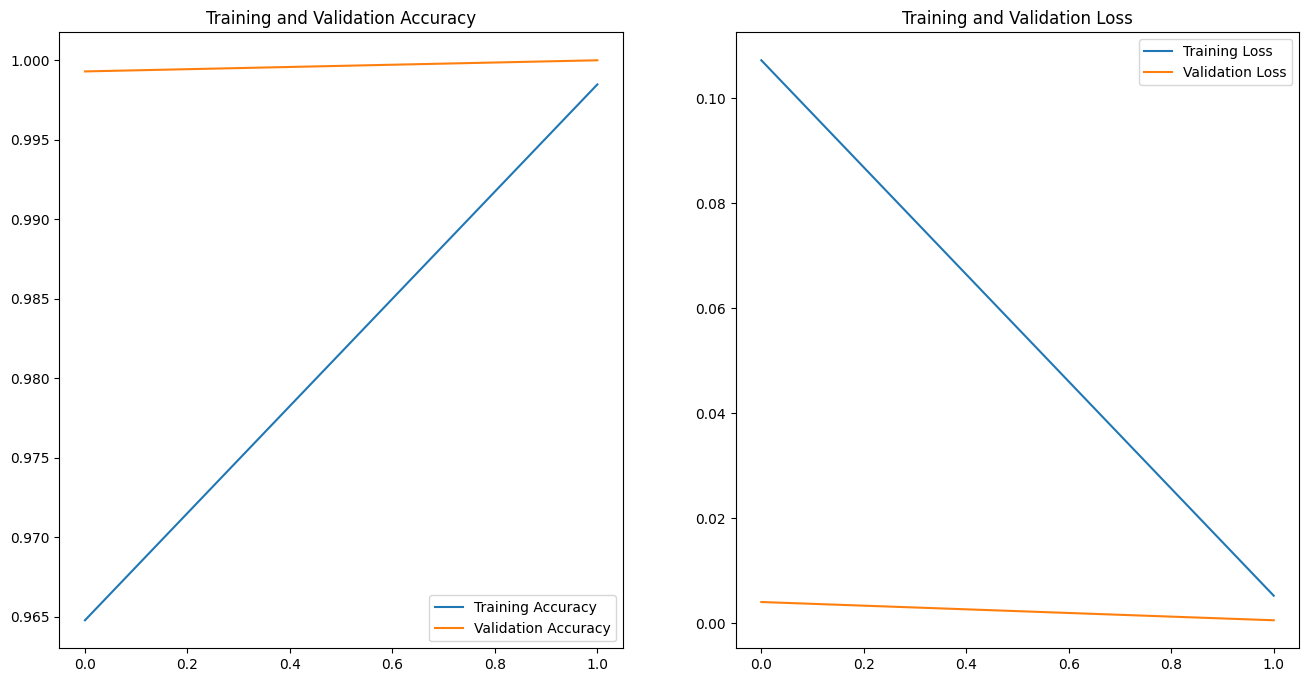

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

In [13]:
epochs=2
history =  model.fit(
  train_set,
  validation_data=test_set,
  epochs=2
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

model.summary()

Le code de la cellule précédente permet d’entrainer le modèle et de suivre l’évolution de la précision et de la perte sur le jeu de données d’entrainement et de test. Qu’observez-vous au niveau de ces courbes ? Vous y voyez des signes de surentrainement ou de sous-entrainement ? Pourquoi ?
<em>À COMPLÉTER</em>

0n remarque que l’évolution des courbes est assez lisse, que feriez-vous si les courbes étaient très bruitées ?

<em>À COMPLÉTER</em>

Il va donc falloir améliorer les performances de notre algorithme d'apprentissage, et notamment gérer ce problème d'apprentissage. Voyons comment on pourrait s'y prendre.

# 5. Techniques de régularisation
Les techniques de régularisation sont les techniques qui visent à réduire le surapprentissage. L’objectif est d’éviter que le réseau de neurones mémorise le jeu de données en s’ajustant bêtement sur les particularités du jeu d’entrainement. Il s’agit globalement de réduire les degrés de liberté du réseau de neurones. Dans le cadre de ce wokrshop nous verrons deux techniques de régularisation :
-	**L’augmentation des données** : Avoir plus de données est toujours bon pour réduire le surapprentissage, d’où l’augmentation des données. Le principe et de rajouter de nouvelles images en effectuant des transformations sur le jeu d’entrainement d’origine. Ces nouvelles images sont obtenues par des transformation affines, ou généralement par des transformations réalistes qui ne change pas la nature du label affectée à l’image. Cette technique est très efficace car les réseaux de neurones sont très gourmands en données.
-	**La technique de dropout** : Cette technique consiste à désactiver, à chaque traitement, les neurones d’une couche dense du réseau de manière aléatoire. Le dropout dépend d’un paramètre qui représente la probabilité de désactivation des neurones de la couche. Cette probabilité est le la proportion moyenne de neurones actives dans la couche durant les itérations de l’entrainement. Elle permet de réduire la complexité du réseau de neurones pour réduire le surapprentissage.

Ces techniques sont utilisés afin de réduire le surapprentissage au niveau des réseaux de neurones. Mais pouvez dire pourquoi l’augmentation des données est utile alors que les données générées sont issues du jeu de données d’entrainement ? Il y aurait vraiment plus d’information contenue dans notre jeu de données que celle qui est déjà présente ? Essayez de prendre un exemple d'image et de réfléchir sur ce qui pourrait se passer si on applique une rotation au niveau de cette image.

<em>À COMPLÉTER</em>
Pouvez-vous détailler en quoi le dropout est utile pour gérer les problèmes de surapprentissage ? Quels sont les avantages du dopout ? Il faut penser en termes de taille du modèle et de sa capacité à mémoriser/apprendre les détails spécifiques au jeu de données.
<em>À COMPLÉTER</em>

Dans les cellules qui suivent, vous allez ré-implémenter le modèle et refaire l’entrainement en incluant une couche de dropout (précédent la couche d’aplatissement), le tout en rajoutant une couche d’augmentation de données. Implémentez tout d'abord le réseau précédent en rajoutant seulement le dropout.

Epoch 1/2
134/134 [==============================] - 67s 495ms/step - loss: 0.2515 - accuracy: 0.9354 - val_loss: 0.0083 - val_accuracy: 0.9986
Epoch 2/2
134/134 [==============================] - 66s 489ms/step - loss: 0.0104 - accuracy: 0.9974 - val_loss: 0.0068 - val_accuracy: 0.9970
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 32)      4640      
                              

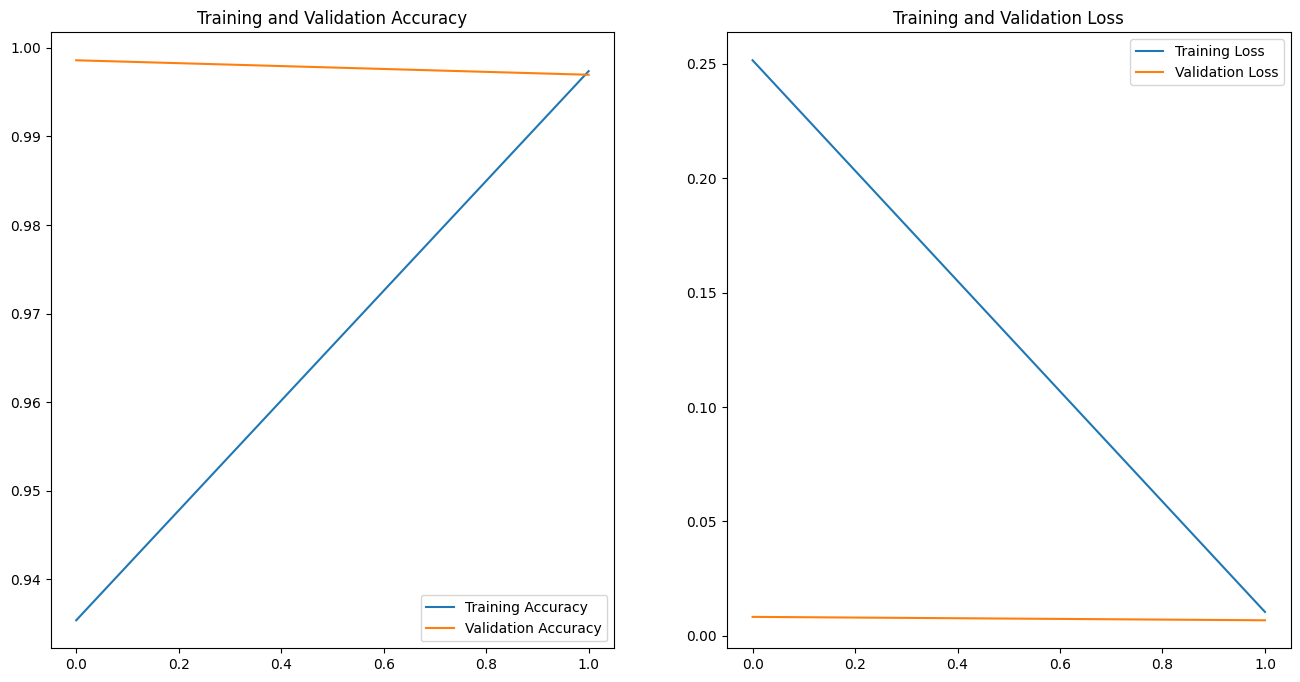

In [15]:
# Le modèle
model_with_dropout = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


# Compilation du modèle
model_with_dropout.compile(optimizer =  "adam",
              loss =  tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Enrainement du modèle
history = model_with_dropout.fit(
  train_set,
  validation_data=test_set,
  epochs=2
)

# Résumé du modèle
model_with_dropout.summary()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Qu'observe-ton au niveau de la perte et de la précision ?
<em>À COMPLÉTER</em>

Passons donc à l'augmentation de données. La couche correspondante vous est fournie ci-dessous. Cette couche parcourt le jeu de données d’entrainement et applique des transformations sur certaines images choisies aléatoirement pour augmenter le jeu de données. On peut imaginer plusieurs types de modifications, en l'occurrence les transformations qu'on va appliquer à chaque image selon une certaine probabilité sont un inversement horizontale de l’image suivi d’une rotation de 18 degrés pour finir avec un zoom vertical de 10%. Complétez-la puis exécutez-la.

In [18]:
data_augmentation = keras.Sequential(
    [
    tf.keras.layers.RandomFlip(
        mode="horizontal_and_vertical"
    ), 
    tf.keras.layers.RandomRotation(
        0.2
    ),  
    tf.keras.layers.RandomZoom(
        height_factor = 0.2,
        width_factor = -0.3,
        fill_mode = "constant",
        interpolation = "bilinear",
    ),
    ]
)

Rajoutez ensuite l'augmentation des données à votre CNN et vérifiez les courbes obtenues après entrainement et évaluation du modèle.

Epoch 1/10
92/92 [==============================] - 34s 336ms/step - loss: 1.3832 - accuracy: 0.3999 - val_loss: 1.1407 - val_accuracy: 0.5300
Epoch 2/10
92/92 [==============================] - 31s 333ms/step - loss: 1.0920 - accuracy: 0.5565 - val_loss: 1.0211 - val_accuracy: 0.5858
Epoch 3/10
92/92 [==============================] - 30s 324ms/step - loss: 1.0229 - accuracy: 0.5978 - val_loss: 1.0214 - val_accuracy: 0.5831
Epoch 4/10
92/92 [==============================] - 30s 325ms/step - loss: 0.9423 - accuracy: 0.6236 - val_loss: 0.9419 - val_accuracy: 0.6294
Epoch 5/10
92/92 [==============================] - 30s 329ms/step - loss: 0.9060 - accuracy: 0.6448 - val_loss: 0.8951 - val_accuracy: 0.6594
Epoch 6/10
92/92 [==============================] - 30s 329ms/step - loss: 0.8876 - accuracy: 0.6522 - val_loss: 0.8859 - val_accuracy: 0.6540
Epoch 7/10
92/92 [==============================] - 31s 333ms/step - loss: 0.8403 - accuracy: 0.6638 - val_loss: 0.9847 - val_accuracy: 0.6335

                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 flatten_2 (Flatten)         (None, 25600)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               3276928   
                                                                 
 dense_5 (Dense)             (None, 5)                 645       
                                                                 
Total params: 3,301,157
Trainable params: 3,301,157
Non-trainable params: 0
_________________________________________________________________


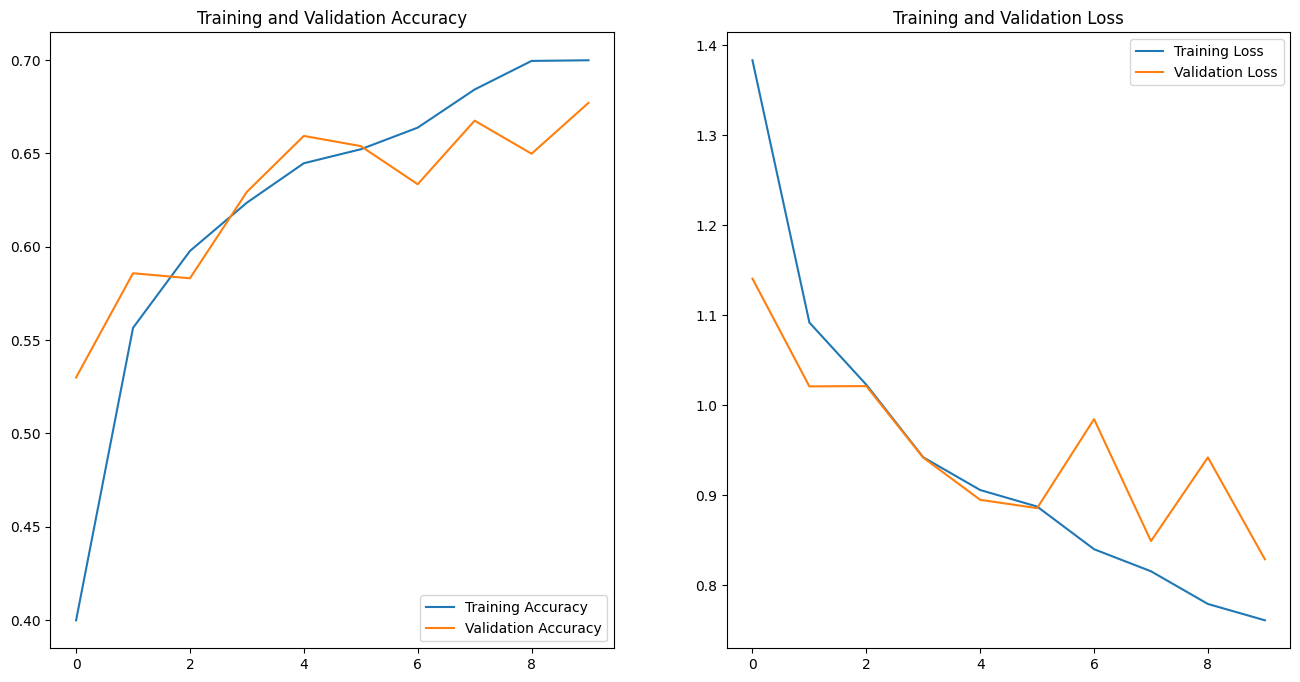

In [22]:
# Le modèle
complete_model = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.5),
    tf.keras.layers.RandomZoom(
        height_factor=0.2,
        width_factor=-0.3,
        fill_mode="constant",
        interpolation="bilinear",
    ),
    tf.keras.layers.Rescaling(1. / 255),
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

# Compilation du modèle
complete_model.compile(optimizer =  "adam",
              loss =  tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Enrainement du modèle
history = complete_model.fit(
  train_set,
  validation_data=test_set,
  epochs=2
)

# Résumé du modèle
complete_model.summary()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Nous observons cette fois une nette amélioration des performances, la précision dans le jeu de test atteint une valeur proche de la précision dans le jeu d’entrainement, et la perte du jeu de test baisse de façon quasi continuelle au cours de l’entrainement. Voilà une bonne nouvelle. Que remarquez-vous d'autre ?
<em>À COMPLÉTER</em>


# 6. Conclusion

Bravo, Vous venez de réaliser votre premier CNN ! Vous avez vu comment implémenter, entrainer et évaluer un CNN ainsi qu’améliorer ses performances grâce à la régularisation. Félicitations !

Mais il vous reste encore beaucoup à apprendre. Tout d'abord, la précision qu'on obtient n’est que de 73% (celle-ci peut être très proche des 100% pour des jeux de données comme MNIST). Ceci n’est pas étonnant vue la taille de votre réseau qui est très petite (le nombre de paramètres des RNs de Google, par exemple, peut atteindre le million voire le milliard).

Évidemment, augmenter la taille du réseau va nettement impacter la rapidité de l'apprentissage. Dans ce cas, l'usage de GPU performants peut améliorer vos performances de manière drastiques, ceux-ci sont très efficaces pour exécuter des  taches de vision. TensorFlow le fait par défaut, mais il est parfois nécessaire d'adapter son fonctionnement, comme par exemple sélectionner le bon GPU (notamment si vous avez un CPU avec un GPU intégré, en général peu performant, et un GPU externe plus puissant). Vous devriez pouvoir trouverfacilement des [ressources abordant le sujet](https://stackoverflow.com/questions/53065420/by-default-does-tensorflow-use-gpu-cpu-simultaneously-for-computing-or-gpu-only).

Il y aurait surement d'autres approches pour améliorer les résultats. Il exister des arhitectures plus évoluées de CNNs, comme par exemple ResNet, qui connecte des couches profondes avec des couches mois profondes.

Et puis, ici on n'a abordé qu’une seule tache de vision par ordinateur, la classification. Or, c'est la plus simple, et celle-ci est rarement utile à elle seule dans un contexte applicatif (comme pour les voitures autonomes, par exemple). Il y a beaucoup d’autres taches de vision par ordinateur toutes plus difficiles les unes que les autres, comme la détection d’objets (mettre des boites et des labels autour des objets), la segmentation d’image (classifier chaque pixel), la reconnaissance faciale, la restauration d’images etc.